# Create Demo Data for Jail

##  Create fake jail data

To create fake PII data, we use the source code from socrates for simulation: https://github.com/Lattice-Works/Socrates-dev/tree/master/resources

(install both butter-fingers and simulator, and a few other dependencies as needed)

In [1]:
from participantgenerator.tablegenerator import subjectgenerator
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import sqlalchemy
import openlattice
import uuid

Define probabilities in demodata

In [2]:
typoness = {
    "firstName": 0.01,
    "middleName": 0.01,
    "lastName": 0.01,
    "ssn": 0,
    "sex": 0.01,
    "dob": 0,
    "race": 0.01,
    "ethnicity": 0.01        
}
missingness = {
    "firstName": 0,
    "middleName": 0,
    "lastName": 0,
    "ssn": 0.1,
    "sex": 0.1,
    "dob": 0,
    "race": 0.1,
    "ethnicity": 0.1
}

# from 2018 census
education_dict = {
    "Elementary or High school, no diploma": 14.2/100,
    "9th grade, no diploma": 7./100,
    "10th grade, no diploma": 7./100,
    "11th grade, no diploma": 7./100,
    "12th grade, no diploma": 4.4/100,
    'Elementary or High school, GED': 28.5/100,
    'High school diploma': 20.5/100,
    "Postsecondary/Some College": 11.4/100
}

# based on customer probabilities > 0.01
reason_dict = {
    'OFA': 0.27,
    'WFA': 0.25,
    'VIEW': 0.17,
    'MO': 0.16,
    'CO': 0.05,
    'PR': 0.03,
    'WRIT': 0.02,
    'BS': 0.01,
    'CIT': 0.01,
    'SENT': 0.01,
    'SWK': 0.01,
    'TC': 0.01}

facility_dict = {
    "SomeJail": 0.25,
    "AnyJail": 0.25,
    "AnotherJail": 0.25,
    "CountyJail": 0.25
}

gender_dict = {
    'Male': 0.650, 
    "Female": 0.1, 
    "Non-Binary": 0.02, 
    "Transgender (Male to Female)": 0.02, 
    "Transgender (Female to Male)": 0.02, 
    "Other": 0.03, 
    "Unknown": 0.02, 
    "Decline to State": 0.12, 
    "Not Asked":0.02
}

marital_dict = {
    'Single': 0.3 , 
    'Married': 0.3, 
    'Widowed': 0.1, 
    'Separated': 0.05, 
    'Divorced': 0.15, 
    'Domestic Partner': 0.05, 
    'Common Law': 0.05
}

In [3]:
# function to get a random date in a predefined year
def random_date_in_year(year):
    startyear = datetime.strptime('1/1/%s 00:00'%year, '%m/%d/%Y %H:%M')
    secondsinyear = 365*24*60*60
    seconds_from_newyear = np.random.randint(low = 0, high = secondsinyear)
    date = startyear + timedelta(seconds = seconds_from_newyear)
    return date

Actually simulate data

In [4]:
dfdict = []

for i in range(100):
    # generate person
    subject = subjectgenerator.subject()
    subject.generate()
    variant = subject.create_variant(typoness, missingness,0 ,0)
    variant['education'] = np.random.choice(list(education_dict.keys()), p = list(education_dict.values()))
    variant['name_id'] = str(uuid.uuid1())
    variant['gender'] = np.random.choice(list(gender_dict.keys()), p = list(gender_dict.values()))

    # helper variables
    bkyear = np.random.randint(low = 12, high = 19)
    bkdate = random_date_in_year(2000+bkyear)
    sentencelengthdays = np.random.randint(low = 0, high = (30 - bkyear)*365)
    reldate = bkdate + timedelta(days = sentencelengthdays)
    ageatbooking = int((bkdate - datetime.strptime(variant['dob'], "%Y-%m-%d")).days/365)

    # generate jailstay
    variant['book_id'] = bkyear + np.random.randint(low = 10000, high = 99999)
    variant['bkstatus'] = np.random.choice(['I', 'A'], p = [0.9, 0.1])
    variant['bookDateTime'] = bkdate.strftime('%m/%d/%Y %H:%M')
    variant['confreason'] = np.random.choice(list(reason_dict.keys()), p = list(reason_dict.values()))
    variant['releasedatetime'] = reldate.strftime('%m/%d/%Y %H:%M') if reldate < datetime.now() else None
    variant['projectedreleasedatetime'] = reldate.strftime('%m/%d/%Y %H:%M')

    # generate jailstaylength
    variant['daysserved'] = sentencelengthdays

    # generate facilities
    variant['facility'] = np.random.choice(list(facility_dict.keys()), p = list(facility_dict.values()))

    # generate hearings
    variant['docketno'] = str(bkyear)+"CR"+str(np.random.randint(low = 10000, high = 99999))

    # generate persondetails
    variant['maritalstatus'] =  np.random.choice(list(marital_dict.keys()), p = list(marital_dict.values())) \
        if ageatbooking > 20 else "Single"
    variant['juvenile'] = "Y" if ageatbooking < 18 else "N"
    
    # generate persondetails sexoffender
    variant['sexoffender'] = np.random.choice(["Y", "N"], p = [0.4, 0.6]) if \
        ageatbooking > 20 else np.random.choice(["Y", "N"], p = [0.4, 0.6])
    
    dfdict.append(variant)

In [5]:
demodata = pd.DataFrame(dfdict)
demodata.head()

,firstName,lastName,middleName,sex,ssn,dob,race,ethnicity,education,name_id,...,bookDateTime,confreason,releasedatetime,projectedreleasedatetime,daysserved,facility,docketno,maritalstatus,juvenile,sexoffender
0,Judy,Bocanegra,E,M,850-03-2335,1958-11-24,Black,Hispanic,High school diploma,5b3f4ca8-3caf-11ea-867b-8c85902f5161,...,08/23/2012 14:43,WFA,None,04/30/2025 14:43,4633,AnotherJail,12CR24738,Married,N,N
1,Michelle,Stallswotth,D,,868-73-5853,1949-10-19,Unknown,Declined,High school diploma,5b4a1888-3caf-11ea-9296-8c85902f5161,...,10/06/2017 17:45,OFA,None,07/21/2023 17:45,2114,AnotherJail,17CR68823,Single,N,N
2,Nicholas,Austin,Mark,M,315-11-3375,2001-01-25,Black,Unknown,"11th grade, no diploma",5b4af848-3caf-11ea-a7cd-8c85902f5161,...,03/29/2014 06:50,WFA,None,11/26/2021 06:50,2799,CountyJail,14CR95665,Single,Y,Y
3,Lucille,Hetz,V,M,,1950-10-19,White,Hispanic,"11th grade, no diploma",5b4fdb88-3caf-11ea-a866-8c85902f5161,...,03/16/2013 05:31,VIEW,None,03/26/2023 05:31,3662,AnyJail,13CR36280,Single,N,N
4,Hector,Hickman,Nina,M,218-88-0334,1932-02-24,,Hispanic,Postsecondary/Some College,5b5474cc-3caf-11ea-8158-8c85902f5161,...,10/11/2014 16:41,OFA,None,03/06/2027 16:41,4529,AnotherJail,14CR81529,Single,N,Y


## Create vizzies

In [6]:
from flighttools import flight, visuals
import openlattice
import os

basedir = "/Users/jokedurnez/Documents/Integrations/FakeIntegrations/DemoData/"
imdir = "/Users/jokedurnez/Documents/Integrations/FakeIntegrations/DemoData/"

baseurl = 'https://api.openlattice.com'
jwt = "***"

configuration = openlattice.Configuration()
configuration.host = baseurl
configuration.api_key_prefix['Authorization'] = 'Bearer'
configuration.api_key['Authorization'] = jwt

edmAPI = openlattice.EdmApi(openlattice.ApiClient(configuration))

In [7]:
filename= os.path.join(basedir,'demo_jail.yaml')
fl = flight.flight(edmAPI=edmAPI)
fl.deserialise(filename)
fl.add_and_check_edm()

Checking property types for association types...
Checking property types for entity types...
Checking entity types in edges...


/Users/jokedurnez/anaconda3/lib/python3.6/site-packages/flighttools-0.0.1-py3.6.egg/flighttools/visuals.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  aesth = yaml.load(infile)


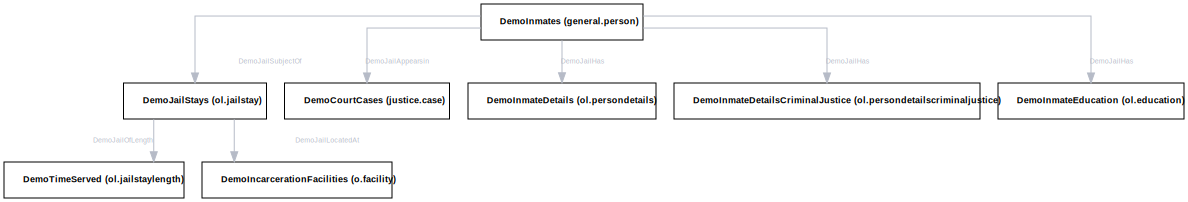

In [8]:
visualisation = visuals.edmViz(flight = fl, engine = "dot", splines = "ortho",
                               aesthetics = {
                                   'entityDefinitions': {
                                       'style': 'square',
                                       'color': 'black',
                                       'fontcolor': 'black',
                                       'titlefontcolor': 'black'
                                   },
                                   'associationDefinitions': {
                                       'color': '#B6BBC7',
                                       'fontcolor': '#B6BBC7'
                               }
                               }
                                   )
tiny = visualisation.create_flight_plot(type="entityset_name")
tiny.format = 'png'
tiny

/Users/jokedurnez/anaconda3/lib/python3.6/site-packages/flighttools-0.0.1-py3.6.egg/flighttools/visuals.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  aesth = yaml.load(infile)


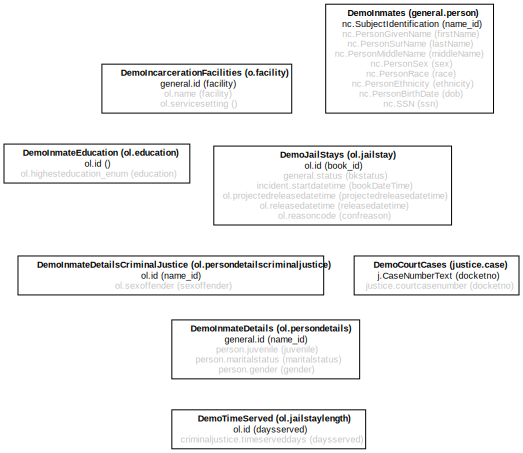

In [9]:
visualisation = visuals.edmViz(flight = fl, engine = "circo", splines = "ortho",
                               aesthetics = {
                                   'entityDefinitions': {
                                       'style': 'square',
                                       'color': 'black',
                                       'fontcolor': 'black',
                                       'titlefontcolor': 'black'
                                   },
                                   'associationDefinitions': {
                                       'color': '#B6BBC7',
                                       'fontcolor': '#B6BBC7'
                               }
                               }
                                   )

vb = visualisation.create_flight_plot(type="entityset_name", fields = ["properties"], plotlinks=False)
vb

In [10]:
cols_fl = fl.get_all_columns()

In [11]:
cols_df = set(demodata.columns)

In [12]:
cols_df - cols_fl

set()

In [13]:
cols_fl - cols_df

set()